### XGBoost 돌리고, parameter들 최적화하는 과정

#### XGBoost 참고자료들
##### 1. 논문: https://arxiv.org/abs/1603.02754
##### 2. 공식문서: https://xgboost.readthedocs.io/en/latest/
##### 3. https://brunch.co.kr/@snobberys/137
##### 4. https://xgboost.readthedocs.io/en/latest/
##### 5. https://blog.naver.com/ydj9398/221403852142
##### 6. http://jetzt.tistory.com/1041

###### XGBoost란
##### 약한 예측 모형을 결합하여 강한 예측모형을 만드는 Boosting 기법의 일종
##### Boosting 기법 예시
###### 어떤 예측 모형 M이 Y를 예측할 확률: Y = M(x) + error(1)
###### error(1)을 더 분류할 수 있는 예측 모형 G: error(1) = G(x) + error(2)
###### error(2)를 더 분류할 수 있는 예측 모형 H: error(2) = H(x) + error(3)
###### 각각의 예측모형에 가중치를 두면 더 좋은 예측 모형이 됨 -> 최종: Y = aM(x) + bG(x) + cH(x) + error(4)
##### XGBoost는 CART(Classification And Regression Tree)라는 앙상블 기법을 활용하여 각각의 예측 모형과 가중치를 계산함
###### XGBoost가 일반적인 의사결정나무(Decision Tree)와 다른점이 CART 기법임. 일반적인 의사결정나무는 트리가 분류를 제대로 했는지에만 관심이 있지만, XGBoost의 CART 기법은 각각의 노드에서 Accuracy Score이 계산되어 최종 Score에 영향을 미치므로 같은 분류이더라도 최종 Score에 따라 모델의 우위를 비교할 수 있음. 
-> 참고자료 3번의 그림 활용하면 더 쉽게 설명 가능할듯 한데, jupyter에 그림을 어떻게 넣죠....ㅜㅜ

In [2]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
# merged set 읽기
merged = pd.read_csv(r'C:\Users\po031\Desktop\merged.csv', encoding = 'utf-8')

In [4]:
# column 보기
merged.columns

Index(['Unnamed: 0', 'date', 'round', 'code', 'distance_x', 'record_x', 'rank',
       'horse_level_num', 'velocity', 'prev1_rank', 'prev2_rank', 'prev3_rank',
       'prev1_velo', 'prev2_velo', 'prev3_velo', 'avg_vel', 'adj_vel',
       'prev1_adjvelo', 'prev2_adjvelo', 'prev3_adjvelo', 'prev_avgvel2',
       'prev_avgrank2', 'failsin2', 'nodata', 'record_y', 'year', 'month',
       'location', 'weather', 'distance_y', 'lane', 'humidity',
       'humidity_dummy', 'sex', 'age', 'raw_weight', 'jockey_w', 'weight_diff',
       'weight_total', 'dandivi', 'yeondivi'],
      dtype='object')

In [5]:
# groupid column을 만들기 위해 location이 nan인 행 제거 후, date와 round 별로 정렬
merged = merged[merged['location'].notnull()]
merged = merged.sort_values(by = ['date', 'round'])
del merged['Unnamed: 0']

In [6]:
# 경기별로 분류하기 위해 date, round, location column을 활용하여 groupid column 추가
merged['groupid'] = merged['date'].apply(str) + merged['round'].apply(str) + merged['location'].apply(str)
idset = list(set(merged['groupid']))
give_ids = dict(list(zip(idset, list(range(len(idset))))))
merged['groupid'] = merged['groupid'].apply(lambda x: give_ids[x])

In [7]:
# train과 test set으로 나누기
# 서울 지역의 경기에만 베팅하므로 test set은 location이 0인 것만 활용
# train/test 1은 근 1년에 베팅하는 모델이며, train/test2는 근 6개월에 베팅하는 모델임
merged_train1 = merged[merged['date'] < 20170901]
merged_test1 = merged[merged['date'] > 20170831]
merged_test1 = merged_test1[merged_test1['date'] < 20181001]
merged_test1 = merged_test1[merged_test1['location'] == 0]
merged_train2 = merged[merged['date'] < 20180301]
merged_test2 = merged[merged['date'] > 20180229]
merged_test2 = merged_test2[merged_test2['date'] < 20181001]
merged_test2 = merged_test2[merged_test2['location'] == 0]

### train/test1을 최적화하는 과정

#### XGBoost 최적화 과정 및 parameter 설명: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

##### max_depth: 트리의 최대 깊이로,클수록 over-fitting 될 수 있음
##### min_child_weight: 가중치를 합한 것의 최소값으로, 클수록 under-fitting 될 수 있음
##### gamma: 가지치기 여부를 결정하는 parameter
##### subsample: 가지치기 할 때마다 관측할 샘플링 비율로, 클수록 over-fitting 될 수 있음
##### colsample_bytree: 가지치기 할 때마다 관측할 feature 비율
##### num_round: 가지치기한 횟수로, 클수록 over-fitting 될 수 있음

In [8]:
# 필요한 변수만 뽑아서 train set 만들기
train1 = pd.DataFrame()
train1['record'] = merged_train1['record_x']
train1['code'] = merged_train1['code']
train1['group_id'] = merged_train1['groupid']
train1['year'] = merged_train1['year']
train1['month'] = merged_train1['month']
train1['location'] = merged_train1['location']
train1['weather'] = merged_train1['weather']
train1['distance'] = merged_train1['distance_x']
train1['round'] = merged_train1['round']
train1['lane'] = merged_train1['lane']
train1['humidity'] = merged_train1['humidity']
train1['humidity_dummy'] = merged_train1['humidity_dummy']
train1['sex'] = merged_train1['sex']
train1['age'] = merged_train1['age']
train1['raw_weight'] = merged_train1['raw_weight']
train1['jockey_w'] = merged_train1['jockey_w']
train1['weight_diff'] = merged_train1['weight_diff']
train1['weight_total'] = merged_train1['weight_total']
train1['rating'] = merged_train1['horse_level_num']
train1['dandivi'] = merged_train1['dandivi']
train1['yeondivi'] = merged_train1['yeondivi']

In [9]:
# 필요한 변수만 뽑아서 test set 만들기
test1 = pd.DataFrame()
test1['record'] = merged_test1['record_x']
test1['code'] = merged_test1['code']
test1['group_id'] = merged_test1['groupid']
test1['year'] = merged_test1['year']
test1['month'] = merged_test1['month']
test1['location'] = merged_test1['location']
test1['weather'] = merged_test1['weather']
test1['distance'] = merged_test1['distance_x']
test1['round'] = merged_test1['round']
test1['lane'] = merged_test1['lane']
test1['humidity'] = merged_test1['humidity']
test1['humidity_dummy'] = merged_test1['humidity_dummy']
test1['sex'] = merged_test1['sex']
test1['age'] = merged_test1['age']
test1['raw_weight'] = merged_test1['raw_weight']
test1['jockey_w'] = merged_test1['jockey_w']
test1['weight_diff'] = merged_test1['weight_diff']
test1['weight_total'] = merged_test1['weight_total']
test1['rating'] = merged_test1['horse_level_num']
test1['dandivi'] = merged_test1['dandivi']
test1['yeondivi'] = merged_test1['yeondivi']

In [10]:
# XGBoost의 feature 지정(record에 영향을 미치는 변수들)
features = ['year', 'month', 'location', 'weather', 'distance', 'round', 'lane', 'humidity', 'humidity_dummy', 'sex', 'age',
            'raw_weight', 'jockey_w', 'weight_diff', 'weight_total', 'rating', 'dandivi', 'yeondivi']

In [11]:
# train, test dataframe을 array로 바꾸기
train_array = train1.as_matrix()
test_array = test1.as_matrix()
    
# 종속변수인 record time을 따로 떼어줌
real1 = train_array[:,0]; real2 = test_array[:,0]
    
# xgb에서 쓸 수 있도록 자료형 변경
xgb_train = xgb.DMatrix(train_array[:,3:], label = real1, feature_names = features) 
xgb_test = xgb.DMatrix(test_array[:,3:], label = real2, feature_names = features)

In [93]:
# XGBoost sample1(max_depth 구하기) 만들기
for i in range(3, 8):
    xgb1 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=i,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb1_param = xgb1.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb1_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('max_depth: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

max_depth: 3, train_error: 1.0608801255547087, test_error: 1.1637264458090906
max_depth: 4, train_error: 1.0267511620739127, test_error: 1.142890546930068
max_depth: 5, train_error: 0.991349941985166, test_error: 1.1711177595049445
max_depth: 6, train_error: 0.9462642702551433, test_error: 1.1536350626875835
max_depth: 7, train_error: 0.8960903946548735, test_error: 1.169552555901795


In [95]:
# XGBoost sample2(min_child_weight 구하기) 만들기
for i in range(1, 3):
    xgb2 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=4,
                             min_child_weight=i,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb2_param = xgb2.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb2_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('min_child_weight: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

min_child_weight: 1, train_error: 1.0267511620739127, test_error: 1.142890546930068
min_child_weight: 2, train_error: 1.0314119249389169, test_error: 1.1436198909586213


In [96]:
# XGBoost sample3(gamma 구하기) 만들기
for i in range(0, 5):
    xgb3 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=4,
                             min_child_weight=1,
                             gamma=i/10,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb3_param = xgb3.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb3_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('gamma: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

gamma: 0, train_error: 1.0267511620739127, test_error: 1.142890546930068
gamma: 1, train_error: 1.0267511620739127, test_error: 1.142890546930068
gamma: 2, train_error: 1.026596341545564, test_error: 1.1430147467120384
gamma: 3, train_error: 1.026596341545564, test_error: 1.1430147467120384
gamma: 4, train_error: 1.026596341545564, test_error: 1.1430147467120384


In [102]:
# XGBoost sample4(subsample 구하기) 만들기
for i in range(73, 78):
    xgb4 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=4,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=i/100,
                             colsample_bytree=1,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb4_param = xgb4.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb4_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('subsample: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

subsample: 73, train_error: 0.9448443168106067, test_error: 1.0484641998800541
subsample: 74, train_error: 0.9417482353594276, test_error: 1.0545772033779595
subsample: 75, train_error: 0.9460561340980773, test_error: 1.0352631526499352


KeyboardInterrupt: 

In [103]:
# XGBoost sample5(colsample_bytree 구하기) 만들기
for i in range(95, 101):
    xgb5 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=4,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=0.75,
                             colsample_bytree=i/100,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb5_param = xgb5.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb5_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('colsample_bytree: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

colsample_bytree: 95, train_error: 0.9501763708680186, test_error: 1.0390681014625156
colsample_bytree: 96, train_error: 0.9501763708680186, test_error: 1.0390681014625156
colsample_bytree: 97, train_error: 0.9501763708680186, test_error: 1.0390681014625156


KeyboardInterrupt: 

In [111]:
# XGBoost sample6(num_round 구하기) 만들기
for i in range(50, 500, 50):
    xgb6 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=4,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=0.75,
                             colsample_bytree=1,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb6_param = xgb6.get_xgb_params()
    
    # train & test
    num_round = i
    bst = xgb.train(xgb6_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test)

    # Mean Absolute Error 출력
    print('num_round: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

num_round: 50, train_error: 1.1144766640314425, test_error: 1.2942233763722477
num_round: 100, train_error: 0.9884393582512517, test_error: 1.1087806198259746
num_round: 150, train_error: 0.9616335298569894, test_error: 1.0492491038811305
num_round: 200, train_error: 0.9460561340980773, test_error: 1.0352631526499352
num_round: 250, train_error: 0.9370615298499256, test_error: 1.031828892221419
num_round: 300, train_error: 0.9286817543500161, test_error: 1.0320901927375394


KeyboardInterrupt: 

In [13]:
# 최적화된 XGBoost
xgb7 = xgb.XGBClassifier(learning_rate=0.1,
                         n_estimators=1000, 
                         max_depth=4,
                         min_child_weight=1,
                         gamma=0.1,
                         subsample=0.75,
                         colsample_bytree=1,
                         objective= 'reg:linear',
                         scale_pos_weight=1,
                         seed=27)
xgb7_param = xgb7.get_xgb_params()
    
# train & test
num_round = 250
bst = xgb.train(xgb7_param, xgb_train, num_round) # 훈련
pred1 = bst.predict(xgb_train) # 예측
pred2 = bst.predict(xgb_test)

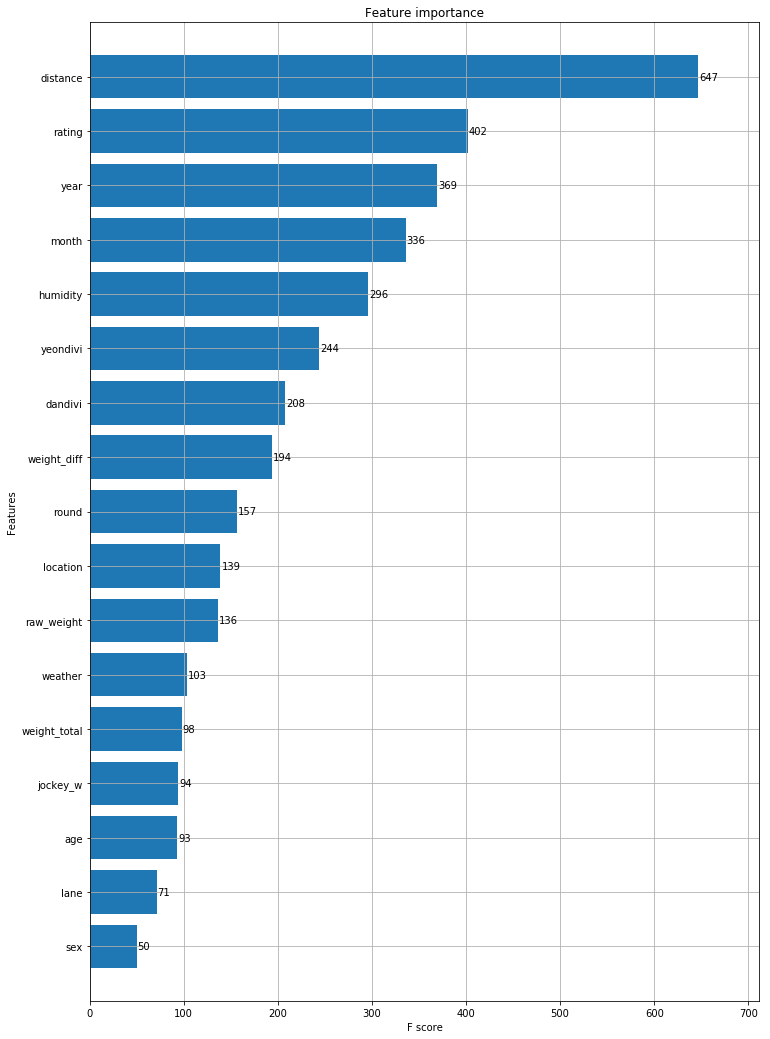

In [14]:
# feature 별 중요도를 보여주는 그래프 그리기
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [15]:
# test1에 pred2(예측된 lap time) 추가
test1 = test1.reset_index()
test1['pred'] = pd.DataFrame(pred2)

In [16]:
# group_id 순으로 정렬
test1 = test1.sort_values(['group_id']).reset_index(drop = True)

In [17]:
# group_id를 중복 제거하여 array로 만들기
test_group_id = test1['group_id']
group_id = np.array(test_group_id.drop_duplicates())

In [18]:
# group_id 별로 예측된 rank column 추가
rank1 = pd.DataFrame()
for i in group_id:
    rank1 = rank1.append(pd.DataFrame(test1[test1['group_id'] == i]['pred'].rank()))
test1['pred_rank'] = rank1

In [19]:
# group_id 별로 실제 rank column 추가
rank2 = pd.DataFrame()
for i in group_id:
    rank2 = rank2.append(pd.DataFrame(test1[test1['group_id'] == i]['record'].rank()))
test1['rank'] = rank2

In [20]:
# 1위로 예측한 것 중 실제 1위한 확률 계산
a = 0
b = 0
for i in test1[test1['pred_rank'] == 1]['rank']:
    if i == 1 or i == 1.5:
        a += 1
        b += 1
    else:
        b += 1
a/b

0.38192668371696503

In [128]:
# test1을 csv 파일로 뽑아내기
test1.to_csv('XGBoost_pred1.csv')

### train/test2를 최적화하는 과정

In [32]:
merged_train2.columns

Index(['date', 'round', 'code', 'distance_x', 'record_x', 'rank',
       'horse_level_num', 'velocity', 'prev1_rank', 'prev2_rank', 'prev3_rank',
       'prev1_velo', 'prev2_velo', 'prev3_velo', 'avg_vel', 'adj_vel',
       'prev1_adjvelo', 'prev2_adjvelo', 'prev3_adjvelo', 'prev_avgvel2',
       'prev_avgrank2', 'failsin2', 'nodata', 'record_y', 'year', 'month',
       'location', 'weather', 'distance_y', 'lane', 'humidity',
       'humidity_dummy', 'sex', 'age', 'raw_weight', 'jockey_w', 'weight_diff',
       'weight_total', 'dandivi', 'yeondivi', 'groupid'],
      dtype='object')

In [59]:
# 필요한 변수만 뽑아서 train set 만들기
train2 = pd.DataFrame()
train2['record'] = merged_train2['record_x']
train2['code'] = merged_train2['code']
train2['group_id'] = merged_train2['groupid']
train2['year'] = merged_train2['year']
train2['month'] = merged_train2['month']
train2['location'] = merged_train2['location']
train2['weather'] = merged_train2['weather']
train2['distance'] = merged_train2['distance_x']
train2['round'] = merged_train2['round']
train2['lane'] = merged_train2['lane']
train2['humidity'] = merged_train2['humidity']
train2['humidity_dummy'] = merged_train2['humidity_dummy']
train2['sex'] = merged_train2['sex']
train2['age'] = merged_train2['age']
train2['raw_weight'] = merged_train2['raw_weight']
train2['jockey_w'] = merged_train2['jockey_w']
train2['weight_diff'] = merged_train2['weight_diff']
train2['weight_total'] = merged_train2['weight_total']
train2['rating'] = merged_train2['horse_level_num']
train2['dandivi'] = merged_train2['dandivi']
train2['yeondivi'] = merged_train2['yeondivi']

In [60]:
# 필요한 변수만 뽑아서 test set 만들기
test2 = pd.DataFrame()
test2['record'] = merged_test2['record_x']
test2['code'] = merged_test2['code']
test2['group_id'] = merged_test2['groupid']
test2['year'] = merged_test2['year']
test2['month'] = merged_test2['month']
test2['location'] = merged_test2['location']
test2['weather'] = merged_test2['weather']
test2['distance'] = merged_test2['distance_x']
test2['round'] = merged_test2['round']
test2['lane'] = merged_test2['lane']
test2['humidity'] = merged_test2['humidity']
test2['humidity_dummy'] = merged_test2['humidity_dummy']
test2['sex'] = merged_test2['sex']
test2['age'] = merged_test2['age']
test2['raw_weight'] = merged_test2['raw_weight']
test2['jockey_w'] = merged_test2['jockey_w']
test2['weight_diff'] = merged_test2['weight_diff']
test2['weight_total'] = merged_test2['weight_total']
test2['rating'] = merged_test2['horse_level_num']
test2['dandivi'] = merged_test2['dandivi']
test2['yeondivi'] = merged_test2['yeondivi']

In [61]:
# XGBoost의 feature 지정(record에 영향을 미치는 변수들)
features = ['year', 'month', 'location', 'weather', 'distance', 'round', 'lane', 'humidity', 'humidity_dummy', 'sex', 'age',
            'raw_weight', 'jockey_w', 'weight_diff', 'weight_total', 'rating', 'dandivi', 'yeondivi']

In [62]:
# train, test dataframe을 array로 바꾸기
train_array = train2.as_matrix()
test_array = test2.as_matrix()
    
# 맨 앞 칼럼이 record time(종속변수)이라서 따로 떼어줌.
real1 = train_array[:,0]; real2 = test_array[:,0]
    
# xgb에서 쓸 수 있도록 자료형 변경
xgb_train = xgb.DMatrix(train_array[:,3:], label = real1, feature_names = features) 
xgb_test = xgb.DMatrix(test_array[:,3:], label = real2, feature_names = features)

In [65]:
# XGBoost sample1(max_depth 구하기) 만들기
for i in range(2, 5):
    xgb1 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=i,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb1_param = xgb1.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb1_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('max_depth: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

max_depth: 2, train_error: 1.025848132288506, test_error: 1.0198528745444106
max_depth: 3, train_error: 0.9782673188675607, test_error: 0.9724935039480619
max_depth: 4, train_error: 0.9479022858690742, test_error: 0.9763592967823305


In [67]:
# XGBoost sample2(min_child_weight 구하기) 만들기
for i in range(4, 9):
    xgb2 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=3,
                             min_child_weight=i,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb2_param = xgb2.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb2_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('min_child_weight: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

min_child_weight: 5, train_error: 0.9774375597534762, test_error: 0.9718390038293931
min_child_weight: 6, train_error: 0.9780265402784818, test_error: 0.9684271260689751
min_child_weight: 7, train_error: 0.9776296460408246, test_error: 0.970143873487939
min_child_weight: 8, train_error: 0.9775254441997935, test_error: 0.973856928004147


In [68]:
# XGBoost sample3(gamma 구하기) 만들기
for i in range(0, 5):
    xgb3 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=3,
                             min_child_weight=4,
                             gamma=i/10,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb3_param = xgb3.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb3_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('gamma: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

gamma: 0, train_error: 0.9780265402784818, test_error: 0.9684271260689751
gamma: 1, train_error: 0.9780265402784818, test_error: 0.9684271260689751
gamma: 2, train_error: 0.9780265402784818, test_error: 0.9684271260689751
gamma: 3, train_error: 0.9780265402784818, test_error: 0.9684271260689751
gamma: 4, train_error: 0.9780265402784818, test_error: 0.9684271260689751


In [77]:
# XGBoost sample4(subsample 구하기) 만들기
for i in range(15, 30, 5):
    xgb4 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=3,
                             min_child_weight=4,
                             gamma=0.1,
                             subsample=i/100,
                             colsample_bytree=1,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb4_param = xgb4.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb4_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('subsample: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

subsample: 75, train_error: 0.9745827563922072, test_error: 0.9777220067390389
subsample: 80, train_error: 0.9780265402784818, test_error: 0.9684271260689751
subsample: 85, train_error: 0.9747619217961081, test_error: 0.9751915845656938


In [79]:
# XGBoost sample5(colsample_bytree 구하기) 만들기
for i in range(90, 105, 5):
    xgb5 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=3,
                             min_child_weight=4,
                             gamma=0.1,
                             subsample=0.2,
                             colsample_bytree=i/100,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb5_param = xgb5.get_xgb_params()
    
    # train & test
    num_round = 200
    bst = xgb.train(xgb5_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측
        
    # Mean Absolute Error 출력
    print('colsample_bytree: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

colsample_bytree: 75, train_error: 0.9822466690152167, test_error: 0.9879366479808444
colsample_bytree: 80, train_error: 0.9780265402784818, test_error: 0.9684271260689751
colsample_bytree: 85, train_error: 0.9769186120591165, test_error: 0.9829022235873236


In [80]:
# XGBoost sample6(num_round 구하기) 만들기
for i in range(50, 500, 50):
    xgb6 = xgb.XGBClassifier(learning_rate=0.1,
                             n_estimators=1000, 
                             max_depth=3,
                             min_child_weight=4,
                             gamma=0.1,
                             subsample=0.2,
                             colsample_bytree=1,
                             objective= 'reg:linear',
                             scale_pos_weight=1,
                             seed=27)
    xgb6_param = xgb6.get_xgb_params()
    
    # train & test
    num_round = i
    bst = xgb.train(xgb6_param, xgb_train, num_round) # 훈련
    pred1 = bst.predict(xgb_train) # 예측
    pred2 = bst.predict(xgb_test) # 예측

    # Mean Absolute Error 출력
    print('num_round: {0}, train_error: {1}, test_error: {2}'.format(i, abs(pred1-real1).mean(), abs(pred2-real2).mean()))

num_round: 50, train_error: 1.2196114588241544, test_error: 1.2108813719498788
num_round: 100, train_error: 1.0325182511270805, test_error: 1.027921699332013
num_round: 150, train_error: 0.9970773170636789, test_error: 0.9846009484434869
num_round: 200, train_error: 0.9780265402784818, test_error: 0.9684271260689751
num_round: 250, train_error: 0.9670622153159425, test_error: 0.9671237928893556
num_round: 300, train_error: 0.9572448016095545, test_error: 0.9649092762598452
num_round: 350, train_error: 0.9506459984065524, test_error: 0.9639585162595304
num_round: 400, train_error: 0.9450744745067383, test_error: 0.9653051812743224


KeyboardInterrupt: 

In [90]:
# 최적화된 XGBoost
xgb7 = xgb.XGBClassifier(learning_rate=0.1,
                         n_estimators=1000, 
                         max_depth=3,
                         min_child_weight=4,
                         gamma=0.1,
                         subsample=0.2,
                         colsample_bytree=1,
                         objective= 'reg:linear',
                         scale_pos_weight=1,
                         seed=27)
xgb7_param = xgb7.get_xgb_params()
    
# train & test
num_round = 300
bst = xgb.train(xgb7_param, xgb_train, num_round) # 훈련
pred1 = bst.predict(xgb_train) # 예측
pred2 = bst.predict(xgb_test) # 예측

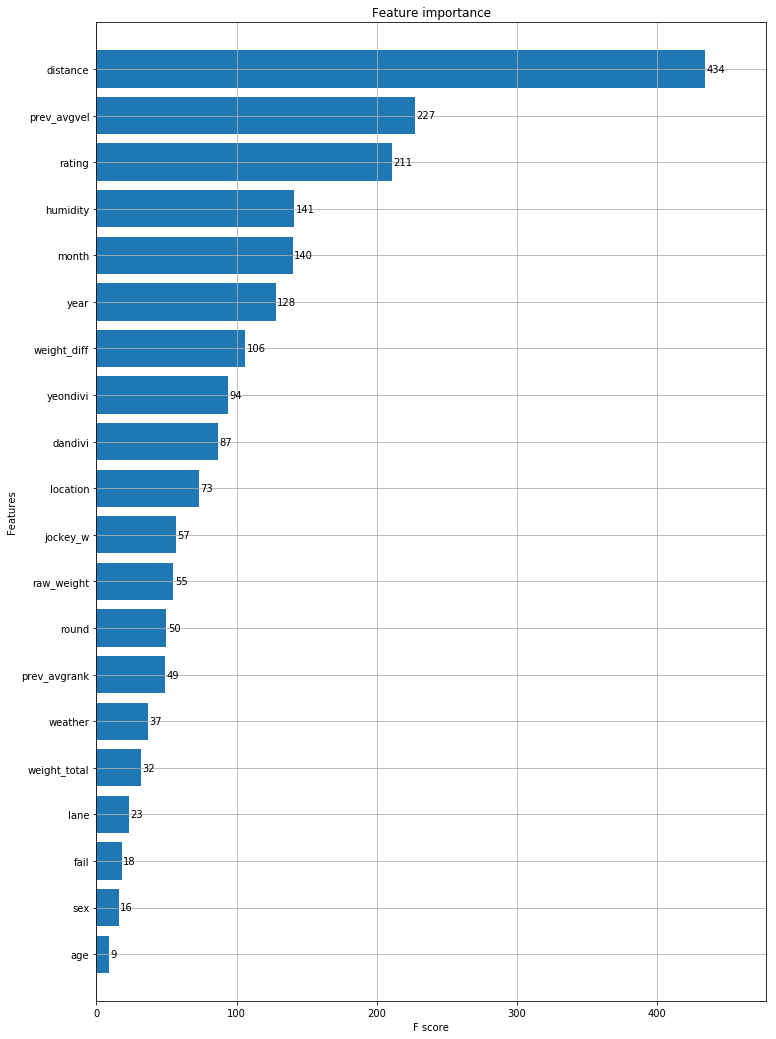

In [91]:
# feature 별 중요도를 보여주는 그래프 그리기
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [83]:
# test2에 pred2 추가
test2 = test2.reset_index()
test2['pred'] = pd.DataFrame(pred2)

In [84]:
# group_id 순으로 정렬
test2 = test2.sort_values(['group_id']).reset_index(drop = True)

In [85]:
# group_id를 중복 제거하여 array로 만들기
test_group_id = test2['group_id']
group_id = np.array(test_group_id.drop_duplicates())

In [86]:
# group_id 별로 예측된 rank column 추가
rank1 = pd.DataFrame()
for i in group_id:
    rank1 = rank1.append(pd.DataFrame(test2[test2['group_id'] == i]['pred'].rank()))
test2['pred_rank'] = rank1

In [87]:
# group_id 별로 실제 rank column 추가
rank2 = pd.DataFrame()
for i in group_id:
    rank2 = rank2.append(pd.DataFrame(test2[test2['group_id'] == i]['record'].rank()))
test2['rank'] = rank2

In [88]:
# 1등으로 예측한 것 중 실제 1등한 확률 계산
a = 0
b = 0
for i in test2[test2['pred_rank'] == 1]['rank']:
    if i == 1 or i == 1.5:
        a += 1
        b += 1
    else:
        b += 1
a/b

0.37422360248447206

In [89]:
# test2를 csv 파일로 뽑기
test2.to_csv('XGBoost_pred2_1.csv')